In [1]:
# Basics
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing

%run utils/feature-extractor/feat_extraction.py

### 1. Loading data

In [2]:
dataset = pkl.load(open('../data/dataset_10M.pkl', 'rb'))
print("Number of samples is", dataset.shape[0])

dataset.head()

Number of samples is 10000000


,index,pu_t,do_t,trip_dist,pu_lon,pu_lat,do_lon,do_lat,duration,vec_dist,trip_ratio
0,0,2016-02-16 19:56:06,2016-02-16 20:10:46,8.53,-73.995750,40.764488,-73.926292,40.867458,880,7.983998,1.068387
1,1,2016-02-11 10:23:41,2016-02-11 10:45:04,1.95,-73.994110,40.751068,-73.993401,40.736019,1283,1.039087,1.876648
2,2,2016-02-21 14:21:57,2016-02-21 14:30:07,0.50,-73.973160,40.752728,-73.982178,40.756962,490,0.556130,0.899070
3,3,2016-02-11 22:51:59,2016-02-11 22:57:41,1.30,-73.991280,40.744808,-73.985909,40.731178,342,0.981839,1.324045
4,4,2016-02-13 18:32:08,2016-02-13 18:43:51,1.50,-73.992897,40.741280,-73.975967,40.748734,703,1.026608,1.461123


In [3]:
dataset[dataset.duration < 0.01].shape

(152, 11)

### 2. Feature Extraction

In [3]:
output = dataset.duration

In [4]:
# Instantiate a (concrete) component
featExtractor = FeatureExtractor(dataset=dataset)

# Decorate with features
featExtractor = CoordinatesFeature(featExtractor)
featExtractor = VectorDistanceFeature(featExtractor)
featExtractor = NaiveTripDistanceFeature(featExtractor)
featExtractor = GridTripDistanceFeature(featExtractor)
featExtractor = AvgHourFeature(featExtractor)
featExtractor = WeekDayFeature(featExtractor)

# Extract them
features = featExtractor.getFeatures()
features.head()

Extracting Coordinates Features...
Extracting VectorDistance Features...
Extracting NaiveTripDistance Features...
Extracting GridTripDistance Features...
Started prediction on grid of size 300x300
Normalizing data...
Prediction has started.
Finished.

Extracting AvgHour Features...
Extracting WeekDay Features...


,pu_lon,pu_lat,do_lon,do_lat,vec_dist,naive_trip_dist,grid_trip_dist,avg_hour,avg_hour_sin,avg_hour_cos,week_day,week_day_sin,week_day_cos
0,-73.995750,40.764488,-73.926292,40.867458,7.983998,10.459038,9.256702,20,-0.866025,5.000000e-01,1,0.781831,0.623490
1,-73.994110,40.751068,-73.993401,40.736019,1.039087,1.361203,1.336709,10,0.500000,-8.660254e-01,3,0.433884,-0.900969
2,-73.973160,40.752728,-73.982178,40.756962,0.556130,0.728530,0.720743,14,-0.500000,-8.660254e-01,6,-0.781831,0.623490
3,-73.991280,40.744808,-73.985909,40.731178,0.981839,1.286210,1.277223,22,-0.500000,8.660254e-01,3,0.433884,-0.900969
4,-73.992897,40.741280,-73.975967,40.748734,1.026608,1.344856,1.314838,18,-1.000000,-1.836970e-16,5,-0.974928,-0.222521


In [5]:
circle1 = plt.Circle((0, 0), 1, fill=False, alpha=.5)
circle2 = plt.Circle((0, 0), 1, fill=False, alpha=.5)

fig, ax = plt.subplots(figsize=(4,4))
ax.add_artist(circle1)
plt.scatter(features.avg_hour_cos, features.avg_hour_sin)
plt.plot((-1,1),(0,0),c='k',alpha=.5)
plt.plot((0,0),(-1,1),c='k',alpha=.5)

limit = 1.1
plt.xlim((-limit,limit))
plt.ylim((-limit,limit))

fig1, ax1 = plt.subplots(figsize=(4,4))
ax1.add_artist(circle2)
plt.scatter(features.week_day_cos, features.week_day_sin)
plt.plot((-1,1),(0,0),c='k',alpha=.5)
plt.plot((0,0),(-1,1),c='k',alpha=.5)
plt.xlim((-limit,limit))
plt.ylim((-limit,limit))
plt.show()

### 3. Scaling

In [6]:
normalized_inputs = features.copy()
normalized_output = output.copy()

In [7]:
lat_data = np.array(pd.concat((features.pu_lat, features.do_lat))).reshape(-1,1)
lon_data = np.array(pd.concat((features.pu_lon, features.do_lon))).reshape(-1,1)
dur_data = np.array(output.astype(float)).reshape(-1,1)

naive_dist_data = np.array(features.naive_trip_dist).reshape(-1,1)
vec_dist_data = np.array(features.vec_dist).reshape(-1,1)
grid_dist_data = np.array(features.grid_trip_dist).reshape(-1,1)


scaler_type = 'StandardScaler' # Other options: MinMaxScaler
lat_scaler = getattr(preprocessing, scaler_type)()
lon_scaler = getattr(preprocessing, scaler_type)()
out_scaler = getattr(preprocessing, scaler_type)()
nai_scaler = getattr(preprocessing, scaler_type)()
vec_scaler = getattr(preprocessing, scaler_type)()
grid_scaler = getattr(preprocessing, scaler_type)()


lat_scaler.fit(lat_data);
lon_scaler.fit(lon_data);

nai_scaler.fit(naive_dist_data);
vec_scaler.fit(vec_dist_data);
grid_scaler.fit(grid_dist_data);


out_scaler.fit(dur_data);

normalized_inputs.pu_lon = lon_scaler.transform(np.array(features.pu_lon).reshape(-1,1))
normalized_inputs.do_lon = lon_scaler.transform(np.array(features.do_lon).reshape(-1,1))
normalized_inputs.pu_lat = lat_scaler.transform(np.array(features.pu_lat).reshape(-1,1))
normalized_inputs.do_lat = lat_scaler.transform(np.array(features.do_lat).reshape(-1,1))


normalized_inputs.naive_trip_dist = nai_scaler.transform(np.array(features.naive_trip_dist).reshape(-1,1))
normalized_inputs.vec_dist = vec_scaler.transform(np.array(features.vec_dist).reshape(-1,1))
normalized_inputs.grid_trip_dist = grid_scaler.transform(np.array(features.grid_trip_dist).reshape(-1,1))

normalized_output = pd.DataFrame(out_scaler.transform(dur_data)).rename(index=int, columns={0: 'duration'})

In [8]:
display(normalized_inputs.head())
display(normalized_output.head())

,pu_lon,pu_lat,do_lon,do_lat,vec_dist,naive_trip_dist,grid_trip_dist,avg_hour,avg_hour_sin,avg_hour_cos,week_day,week_day_sin,week_day_cos
0,-0.618153,0.438220,1.350339,3.926724,2.505878,2.505878,1.943777,20,-0.866025,5.000000e-01,1,0.781831,0.623490
1,-0.571665,-0.016438,-0.551556,-0.526279,-0.443558,-0.443558,-0.434851,10,0.500000,-8.660254e-01,3,0.433884,-0.900969
2,0.022083,0.039781,-0.233493,0.183234,-0.648665,-0.648665,-0.619845,14,-0.500000,-8.660254e-01,6,-0.781831,0.623490
3,-0.491446,-0.228516,-0.339226,-0.690281,-0.467870,-0.467870,-0.452716,22,-0.500000,8.660254e-01,3,0.433884,-0.900969
4,-0.537286,-0.348061,-0.057487,-0.095531,-0.448858,-0.448858,-0.441419,18,-1.000000,-1.836970e-16,5,-0.974928,-0.222521


,duration
0,0.148974
1,0.822718
2,-0.503036
3,-0.750465
4,-0.146938


In [9]:
data = pd.concat([normalized_inputs, normalized_output],axis=1)
data.drop(['avg_hour','week_day','naive_trip_dist'],axis=1,inplace=True)

In [10]:
pkl.dump(data, open('../features_extracted/taxi_trip_data_normalized_10M.dat', 'wb'))

In [11]:
pkl.dump(lat_scaleraler, open('../features_extracted/scalers/lat_scaler.scl', 'wb'))
pkl.dump(lon_scaler, open('../features_extracted/scalers/lon_scaler.scl', 'wb'))
pkl.dump(nai_scaler, open('../features_extracted/scalers/nai_scaler.scl', 'wb'))
pkl.dump(vec_scaler, open('../features_extracted/scalers/vec_scaler.scl', 'wb'))
pkl.dump(grid_scaler, open('../features_extracted/scalers/grid_scaler.scl', 'wb'))
pkl.dump(out_scaler, open('../features_extracted/scalers/out_scaler.scl', 'wb'))

In [5]:
data = pkl.load(open('../features_extracted/taxi_trip_data_normalized_10M.dat', 'rb'))
features = data[:10000]

### Plotting circular variables

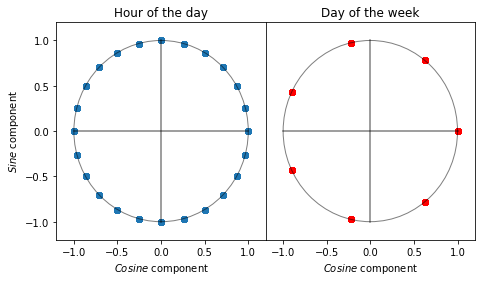

In [61]:
circle1 = plt.Circle((0, 0), 1, fill=False, alpha=.5)
circle2 = plt.Circle((0, 0), 1, fill=False, alpha=.5)

fig, ax = plt.subplots(figsize=(7.5,4))
plt.subplot(121)
ax = plt.gca()
ax.add_artist(circle1)
plt.scatter(features.avg_hour_cos, features.avg_hour_sin)
plt.plot((-1,1),(0,0),c='k',alpha=.5)
plt.plot((0,0),(-1,1),c='k',alpha=.5)
plt.title('Hour of the day')

limit = 1.2
plt.xlim((-limit,limit))
plt.ylim((-limit,limit))

plt.xlabel('$Cosine$ component')
plt.ylabel('$Sine$ component')

plt.subplot(122)
ax1 = plt.gca()
ax1.add_artist(circle2)
plt.scatter(features.week_day_cos, features.week_day_sin,c='r')
plt.plot((-1,1),(0,0),c='k',alpha=.5)
plt.plot((0,0),(-1,1),c='k',alpha=.5)

plt.yticks([])
plt.title('Day of the week')
plt.xlabel('$Cosine$ component')

plt.subplots_adjust(wspace=.0)

plt.xlim((-limit,limit))
plt.ylim((-limit,limit))

plt.savefig('../figures/circular_variables.png', dpi=500);    
plt.show()